In [1]:
%load_ext jupyter_black
%matplotlib inline

Here we will test parameter recovery and model comparison for Rescorla-Wagner (RW), Hierarchical Gaussian Filters (HGF), and Switching Gaussian Filters (SGF) models of the social influence task.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="white", color_codes=True)


def posterior_accuracy(labels, df, vals, nsub):
    for i, lbl in enumerate(labels):
        std = (
            df.loc[df["parameter"] == lbl, ["subject", "value"]]
            .groupby(by="subject")
            .std()
        )
        mean = (
            df.loc[df["parameter"] == lbl, ["subject", "value"]]
            .groupby(by="subject")
            .mean()
        )
        print(
            lbl,
            np.sum(
                ((mean + 2 * std).values[:, 0] > vals[i])
                * ((mean - 2 * std).values[:, 0] < vals[i])
            )
            / (2 * nsub),
        )

Lets start by generating some behavioral data from the social influence task. Here green advice/choice is encoded as 0 and the blue advice/choice is encoded as 1.

In [3]:
import torch
from torch import tensor

from pybefit.tasks import SocialInfluence
from pybefit.simulate import Simulator
from pybefit.inference import NormalGamma as Prior
from pybefit.inference import NormalGammaPosterior as Posterior
from pybefit.agents.torch import RLSocInf, HGFSocInf, SGFSocInf
from pybefit.inference.methods import (
    run_svi,
    default_dict_pyro_svi,
    format_posterior_samples,
)
from pybefit.inference.models import PyroModel, PyroGuide
from pybefit.inference.pyro.likelihoods import befit_likelihood as likelihood

torch.manual_seed(1234)

nsub = 50  # number of subjects
trials = 120  # number of trials/responses


# transform from unconstrained parameters to constrained ones for any agent
def transform(z, model, *args, **kwargs):
    runs, _ = z.shape[-2:]
    # map z variables to model parameters
    agent = model(runs=runs, trials=trials)
    agent.set_parameters(z)

    return agent


# load stimuli (trial offers, advices, and reliability of advices)
reliability = torch.from_numpy(np.load("advice_reliability.npy")).float()
reliability = (
    reliability.reshape(trials, -1, 1)
    .repeat(1, 1, nsub)
    .reshape(trials, -1)
    .unsqueeze(0)
)

offers = (
    torch.from_numpy(np.load("offers.npy"))
    .reshape(trials, -1, 1)
    .repeat(1, 1, nsub)
    .reshape(trials, -1)
    .unsqueeze(0)
)

stimuli = {"offers": offers, "reliability": reliability}

# RL agent
trans_pars1 = torch.arange(-1.0, 1.0, 2.0 / (2 * nsub)).reshape(-1, 1) + tensor(
    [[-2.0, 2.0, 2.0, 0.0]]
)
rl_agent = transform(trans_pars1, RLSocInf)

# HGF agent
hgf_agent = HGFSocInf(runs=2 * nsub, trials=trials)

trans_pars2 = torch.arange(-1.0, 1.0, 2.0 / (2 * nsub)).reshape(-1, 1) + tensor(
    [[0.0, 0.0, 2.0, 2.0, 0.0]]
)
hgf_agent = transform(trans_pars2, HGFSocInf)

# SGF agent
sgf_agent = SGFSocInf(runs=2 * nsub, trials=trials)

trans_pars3 = torch.arange(-1.0, 1.0, 2.0 / (2 * nsub)).reshape(-1, 1) + tensor(
    [[-1.0, 0.0, 2.0, 2.0, 0.0]]
)
sgf_agent = transform(trans_pars3, SGFSocInf)

# simulate behaviour
sim = Simulator(
    [
        SocialInfluence(stimuli, nsub=nsub),
        SocialInfluence(stimuli, nsub=nsub),
        SocialInfluence(stimuli, nsub=nsub),
    ],
    [rl_agent, hgf_agent, sgf_agent],
    trials=trials,
)
sim.simulate_experiment()

stimuli, responses = sim.format_stimuli_and_responses()

plot performance of different agents in different blocks

RL agent:  [0.60833335 0.65      ]
HGF agent:  [0.60833335 0.65      ]
SGF agent:  [0.65 0.65]


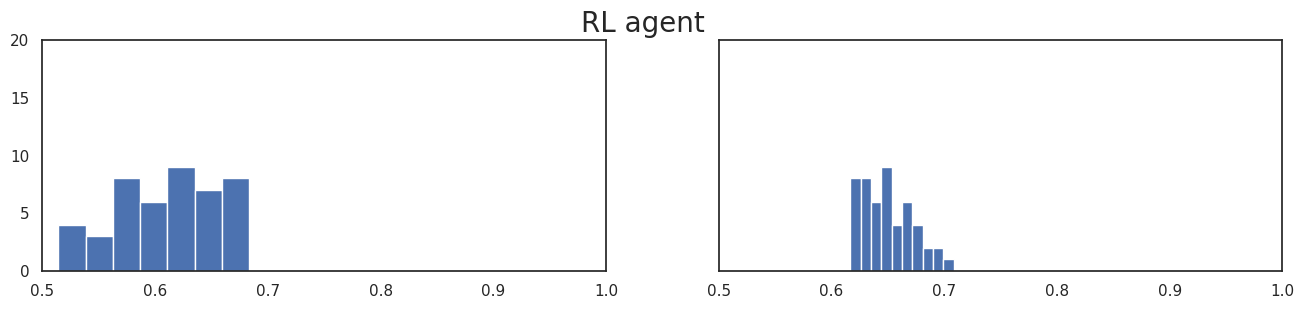

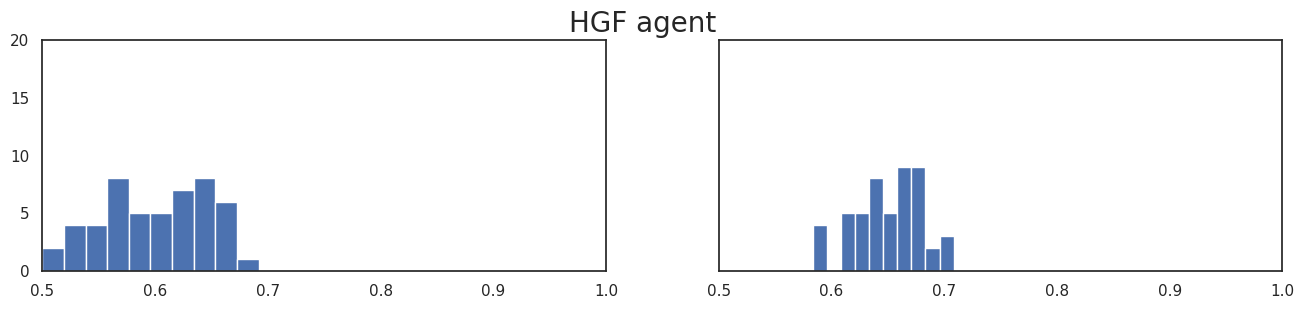

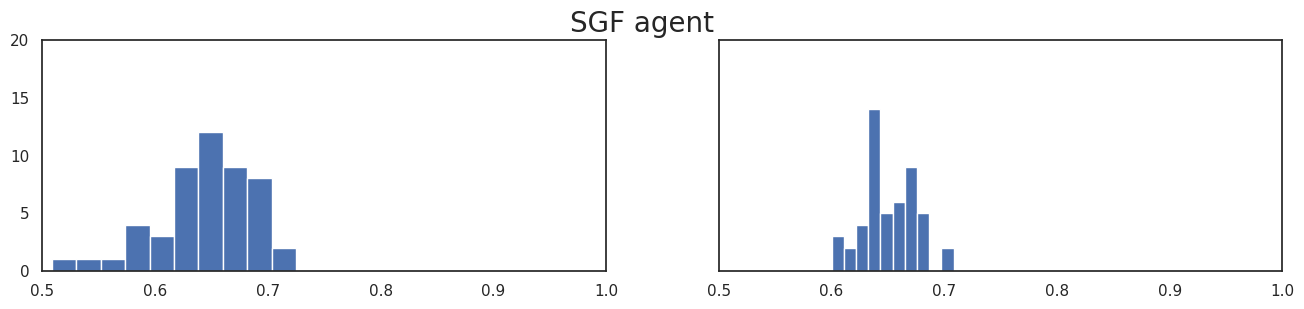

In [4]:
def compute_mean_performance(outcomes, responses):
    cc1 = (outcomes * responses > 0.0).float()  # accept reliable offer
    cc2 = (outcomes * (1 - responses) < 0.0).float()  # reject unreliable offer

    return torch.einsum("ijk->k", cc1 + cc2) / trials


perf1 = (
    compute_mean_performance(
        stimuli["pair_0"]["outcomes"][..., 0].float(), responses["pair_0"].float()
    )
    .numpy()
    .reshape(2, -1)
)

print("RL agent: ", np.median(perf1, axis=-1))

fig, ax = plt.subplots(1, 2, figsize=(16, 3), sharex=True, sharey=True)
ax[0].hist(perf1[0])
ax[1].hist(perf1[1])
fig.suptitle("RL agent", fontsize=20)
ax[0].set_ylim([0, 20])
ax[0].set_xlim([0.5, 1.0])

perf2 = (
    compute_mean_performance(
        stimuli["pair_1"]["outcomes"][..., 0].float(), responses["pair_1"].float()
    )
    .numpy()
    .reshape(2, -1)
)
print("HGF agent: ", np.median(perf2, axis=-1))

fig, ax = plt.subplots(1, 2, figsize=(16, 3), sharex=True, sharey=True)
ax[0].hist(perf2[0])
ax[1].hist(perf2[1])
fig.suptitle("HGF agent", fontsize=20)
ax[0].set_ylim([0, 20])
ax[0].set_xlim([0.5, 1.0])

perf3 = (
    compute_mean_performance(
        stimuli["pair_2"]["outcomes"][..., 0].float(), responses["pair_2"].float()
    )
    .numpy()
    .reshape(2, -1)
)
print("SGF agent: ", np.median(perf3, axis=-1))

fig, ax = plt.subplots(1, 2, figsize=(16, 3), sharex=True, sharey=True)
ax[0].hist(perf3[0])
ax[1].hist(perf3[1])
fig.suptitle("SGF agent", fontsize=20)
ax[0].set_ylim([0, 20])
ax[0].set_xlim([0.5, 1.0]);

Fit simulated behavior

In [5]:
transform_rl = lambda z, *args, **kwargs: transform(z, RLSocInf, *args, **kwargs)

measurments = stimuli["pair_0"]
measurments.update({"mask": torch.ones(1, 120, 100), "responses": responses["pair_0"]})

num_params = 4
num_agents = 2 * nsub
num_samples = 100

prior = Prior(num_params, num_agents, backend="pyro")

posterior = PyroGuide(Posterior(num_params, num_agents, backend="pyro"))


opts_task = {"num_blocks": 1, "num_trials": trials, "num_agents": num_agents}

opts_model = {"prior": {}, "transform": {}, "likelihood": opts_task}

rl_gen_model = PyroModel(prior, transform_rl, likelihood, opts=opts_model)


# perform inference using stochastic variational inference
opts_svi = default_dict_pyro_svi
opts_svi.update({"sample_kwargs": {"num_samples": num_samples}, "iter_steps": 5_000})

samples, svi, results = run_svi(rl_gen_model, posterior, measurments, opts=opts_svi)
var_names = ["alpha", "zeta", "beta", "bias"]
tp_df, par_df = format_posterior_samples(var_names, samples, transform_rl)

  0%|          | 0/5000 [00:00<?, ?it/s]

ValueError: Expected parameter logits (Tensor of shape (100, 2)) of distribution Categorical(logits: torch.Size([100, 2])) to satisfy the constraint IndependentConstraint(Real(), 1), but found invalid values:
tensor([[-8.0121e-01, -5.9563e-01],
        [-1.3887e-01, -2.0428e+00],
        [-7.9614e-01, -5.9978e-01],
        [-1.0283e-01, -2.3256e+00],
        [-9.6224e-01, -4.8133e-01],
        [-1.6992e-01, -1.8562e+00],
        [-4.6654e-03, -5.3699e+00],
        [-6.8789e-01, -6.9843e-01],
        [-3.5485e-01, -1.2082e+00],
        [-2.6219e-01, -1.4669e+00],
        [-5.8526e-02, -2.8674e+00],
        [-3.6064e-01, -1.1948e+00],
        [-1.1327e-01, -2.2341e+00],
        [-1.3849e-01, -2.0454e+00],
        [-1.8231e+00, -1.7617e-01],
        [-6.3356e-01, -7.5651e-01],
        [-3.9958e-01, -1.1105e+00],
        [-1.8845e-02, -3.9809e+00],
        [-9.3814e-02, -2.4130e+00],
        [-2.2457e-02, -3.8074e+00],
        [-2.2709e-01, -1.5938e+00],
        [-3.7132e-01, -1.1706e+00],
        [-8.3550e-02, -2.5238e+00],
        [-2.1042e-01, -1.6620e+00],
        [-7.6524e-01, -6.2590e-01],
        [       -inf,         nan],
        [-6.2066e-01, -7.7130e-01],
        [-1.0489e+00, -4.3127e-01],
        [-3.4550e-01, -1.2305e+00],
        [-2.9607e-01, -1.3615e+00],
        [-9.2197e-01, -5.0706e-01],
        [-1.8434e-01, -1.7817e+00],
        [-6.3957e-02, -2.7814e+00],
        [-1.5371e-01, -1.9486e+00],
        [-6.0781e-01, -7.8645e-01],
        [-2.4849e-01, -1.5140e+00],
        [-2.6164e-01, -1.4688e+00],
        [-1.1184e-01, -2.2461e+00],
        [-8.7560e-02, -2.4789e+00],
        [-9.8977e-02, -2.3620e+00],
        [-8.9862e-01, -5.2278e-01],
        [-1.7710e-01, -1.8183e+00],
        [-1.7116e-01, -1.8495e+00],
        [-3.0864e-01, -1.3259e+00],
        [-6.2337e-01, -7.6816e-01],
        [-8.6643e-01, -5.4550e-01],
        [-8.4977e-02, -2.5076e+00],
        [-7.7394e-02, -2.5973e+00],
        [-4.6164e-01, -9.9493e-01],
        [-4.8268e-02, -3.0550e+00],
        [-3.7103e-01, -1.1712e+00],
        [-1.8611e-01, -1.7730e+00],
        [-1.4776e-01, -1.9852e+00],
        [-2.1124e-01, -1.6585e+00],
        [-1.3954e-01, -2.0384e+00],
        [-2.4416e-01, -1.5295e+00],
        [-4.3507e-01, -1.0419e+00],
        [-4.6183e-02, -3.0981e+00],
        [-1.8283e-01, -1.7892e+00],
        [-7.2421e-01, -6.6302e-01],
        [-7.4811e-01, -6.4105e-01],
        [-5.3642e-01, -8.7909e-01],
        [-3.3993e-02, -3.3985e+00],
        [-1.2838e-01, -2.1163e+00],
        [-1.7658e-01, -1.8210e+00],
        [-6.7072e-02, -2.7353e+00],
        [-1.3644e+00, -2.9508e-01],
        [-3.7651e-01, -1.1592e+00],
        [-3.2908e-02, -3.4304e+00],
        [-3.9441e-02, -3.2526e+00],
        [-2.6556e-02, -3.6418e+00],
        [-5.2361e-01, -8.9742e-01],
        [-1.2757e+00, -3.2745e-01],
        [-1.1186e-01, -2.2459e+00],
        [-5.6333e-01, -8.4236e-01],
        [-7.0286e-01, -6.8352e-01],
        [-1.8902e-01, -1.7589e+00],
        [-3.2316e-01, -1.2869e+00],
        [-1.9224e-01, -1.7436e+00],
        [-4.9303e-02, -3.0343e+00],
        [-3.3043e-01, -1.2680e+00],
        [-5.5643e-01, -8.5156e-01],
        [-2.8200e-01, -1.4035e+00],
        [-6.7436e-02, -2.7301e+00],
        [-1.9500e-01, -1.7307e+00],
        [-1.8261e-01, -1.7903e+00],
        [-1.1711e-01, -2.2026e+00],
        [-5.6252e-01, -8.4344e-01],
        [-7.3110e-02, -2.6521e+00],
        [-6.1534e-01, -7.7753e-01],
        [-4.1083e-01, -1.0880e+00],
        [-6.6734e-01, -7.1964e-01],
        [-4.3041e-01, -1.0505e+00],
        [-1.9882e-01, -1.7131e+00],
        [-1.0085e+00, -4.5374e-01],
        [-5.7826e-01, -8.2297e-01],
        [-4.1272e-01, -1.0843e+00],
        [-9.6831e-02, -2.3828e+00],
        [-5.2182e-01, -9.0003e-01],
        [-1.7561e-01, -1.8260e+00]])
     Trace Shapes:        
      Param Sites:        
     Sample Sites:        
      var_tau dist     | 4
             value     | 4
        sigma dist     | 4
             value     | 4
mu_decentered dist     | 4
             value     | 4
           mu dist     | 4
             value     | 4
       agents dist     |  
             value 100 |  
 z_decentered dist 100 | 4
             value 100 | 4
            z dist 100 | 4
             value 100 | 4
         runs dist     |  
             value 100 |  
      obs_0_0 dist 100 |  
             value 100 |  
      obs_0_1 dist 100 |  
             value 100 |  
      obs_0_2 dist 100 |  
             value 100 |  
      obs_0_3 dist 100 |  
             value 100 |  
      obs_0_4 dist 100 |  
             value 100 |  
      obs_0_5 dist 100 |  
             value 100 |  
      obs_0_6 dist 100 |  
             value 100 |  
      obs_0_7 dist 100 |  
             value 100 |  
      obs_0_8 dist 100 |  
             value 100 |  
      obs_0_9 dist 100 |  
             value 100 |  
     obs_0_10 dist 100 |  
             value 100 |  
     obs_0_11 dist 100 |  
             value 100 |  

Compute fit quality and plot posterior estimates from a hierarchical parameteric model

In [ ]:
labels = [r"$\alpha$", r"$\zeta$", r"$\beta$", r"$\theta$"]
trans_pars_rl = tp_df.melt(id_vars="subject", var_name="parameter")

vals = [
    trans_pars1[:, 0].numpy(),
    trans_pars1[:, 1].numpy(),
    trans_pars1[:, 2].numpy(),
    trans_pars1[:, 3].numpy(),
]
posterior_accuracy(var_names, trans_pars_rl, vals, nsub)

alpha 0.96
zeta 0.94
beta 1.0
bias 0.93


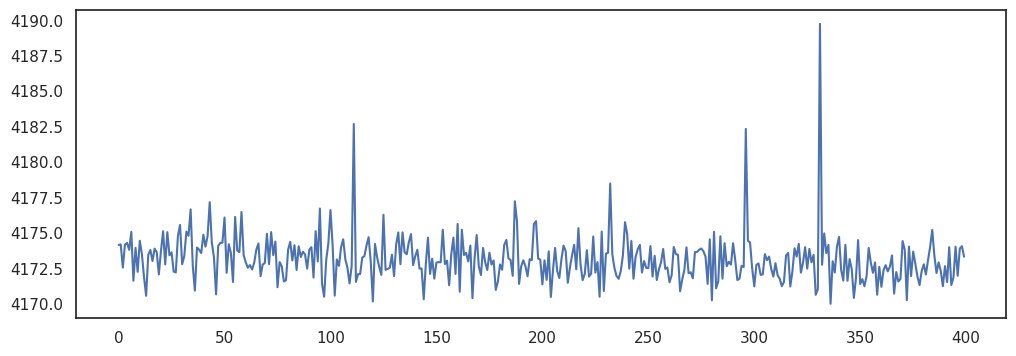

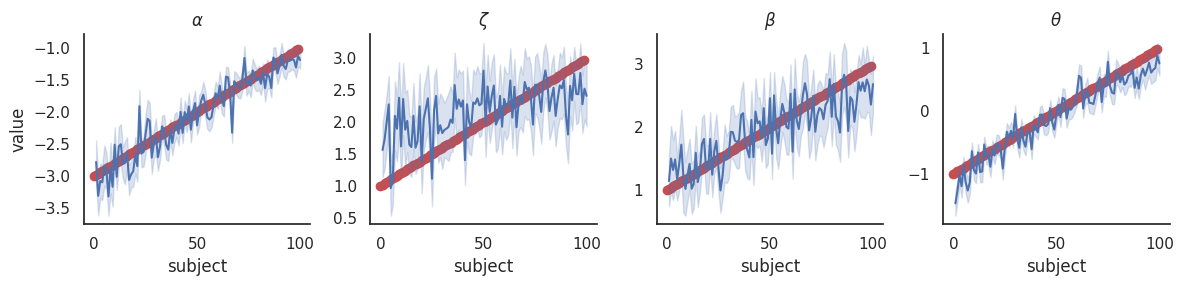

In [ ]:
plt.figure(figsize=(12, 4))
# plot convergence of stochasitc ELBO estimates (log-model evidence)
plt.plot(results["loss"][-400:])

g = sns.FacetGrid(trans_pars_rl, col="parameter", height=3, sharey=False)
g = g.map(sns.lineplot, "subject", "value", errorbar="sd")

labels = [r"$\alpha$", r"$\zeta$", r"$\beta$", r"$\theta$"]
for i in range(len(labels)):
    g.axes[0, i].plot(np.arange(2 * nsub), trans_pars1[:, i].numpy(), "ro", zorder=0)
    g.axes[0, i].set_title(labels[i])

fit HGF agent to simulated data

In [ ]:
transform_hgf = lambda z, *args, **kwargs: transform(z, HGFSocInf, *args, **kwargs)

measurments = stimuli["pair_1"]
measurments.update({"mask": torch.ones(1, 120, 100), "responses": responses["pair_1"]})

num_params = 5
num_agents = 2 * nsub
num_samples = 100

prior = Prior(num_params, num_agents, backend="pyro")

posterior = PyroGuide(
    Posterior(num_params, num_agents, backend="pyro")
)

opts_task = {"num_blocks": 1, "num_trials": trials, "num_agents": num_agents}

opts_model = {"prior": {}, "transform": {}, "likelihood": opts_task}

hgf_gen_model = PyroModel(prior, transform_hgf, likelihood, opts=opts_model)

# perform inference using stochastic variational inference
opts_svi = default_dict_pyro_svi
opts_svi.update({"sample_kwargs": {"num_samples": num_samples}, "iter_steps": 5_000})

samples, svi, results = run_svi(hgf_gen_model, posterior, measurments, opts=opts_svi)
var_names = ["mu0_2", "eta", "zeta", "beta", "bias"]
hgf_tp_df, hgf_par_df = format_posterior_samples(var_names, samples, transform_hgf)

  0%|          | 0/5000 [00:00<?, ?it/s]

In [ ]:
trans_pars_hgf = hgf_tp_df.melt(id_vars="subject", var_name="parameter")

vals = [trans_pars2[:, i].numpy() for i in range(len(var_names))]
posterior_accuracy(var_names, trans_pars_hgf, vals, nsub)

mu0_2 0.9
eta 0.0
zeta 0.94
beta 0.93
bias 0.96


Plot posterior estimates from simulated data for the HGF agent

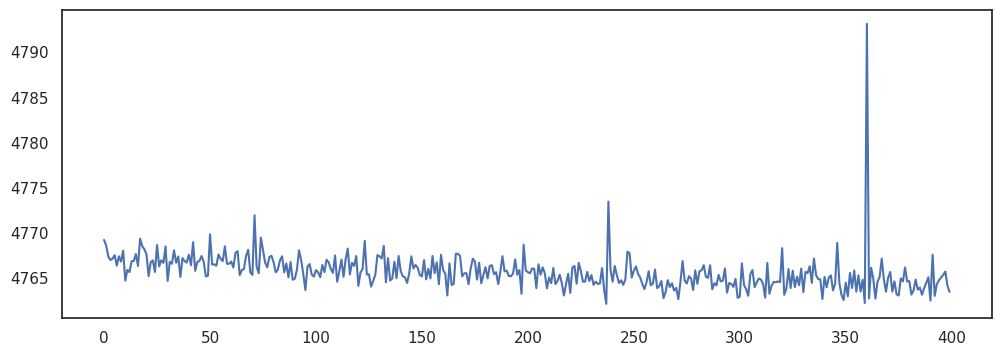

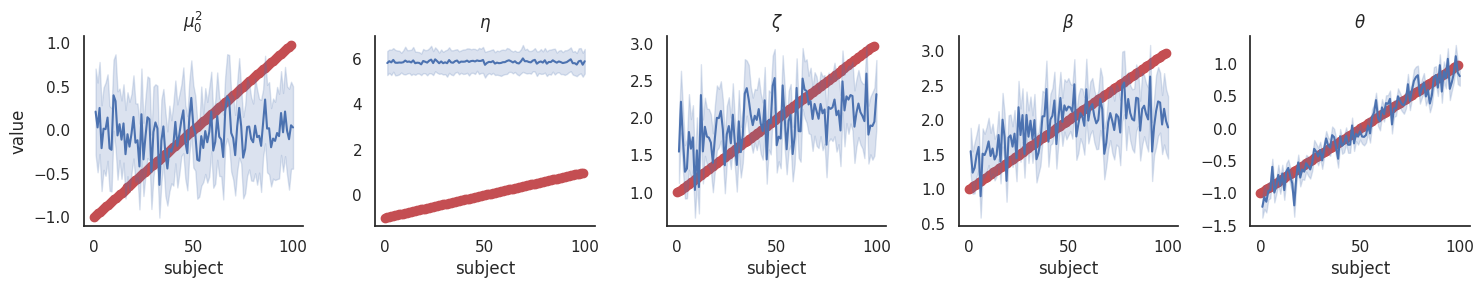

In [ ]:
plt.figure(figsize=(12, 4))
# plot convergence of stochasitc ELBO estimates (log-model evidence)
plt.plot(results["loss"][-400:])

g = sns.FacetGrid(trans_pars_hgf, col="parameter", height=3, sharey=False)
g = g.map(sns.lineplot, "subject", "value", errorbar="sd")

labels = [r"$\mu_0^2$", r"$\eta$", r"$\zeta$", r"$\beta$", r"$\theta$"]
for i in range(len(labels)):
    g.axes[0, i].plot(np.arange(2 * nsub), trans_pars2[:, i].numpy(), "ro", zorder=0)
    g.axes[0, i].set_title(labels[i])

In [ ]:
transform_sgf = lambda z, *args, **kwargs: transform(z, SGFSocInf, *args, **kwargs)

measurments = stimuli["pair_2"]
measurments.update({"mask": torch.ones(1, 120, 100), "responses": responses["pair_2"]})

num_params = 5
num_agents = 2 * nsub
num_samples = 100

prior = Prior(num_params, num_agents, backend="pyro")

posterior = PyroGuide(
    Posterior(num_params, num_agents, backend="pyro")
)

opts_task = {"num_blocks": 1, "num_trials": trials, "num_agents": num_agents}

opts_model = {"prior": {}, "transform": {}, "likelihood": opts_task}

sgf_gen_model = PyroModel(prior, transform_sgf, likelihood, opts=opts_model)

# perform inference using stochastic variational inference
opts_svi = default_dict_pyro_svi
opts_svi.update({"sample_kwargs": {"num_samples": num_samples}, "iter_steps": 5_000})

samples, svi, results = run_svi(sgf_gen_model, posterior, measurments, opts=opts_svi)
var_names = ["rho1", "h", "zeta", "beta", "bias"]
sgf_tp_df, sgf_par_df = format_posterior_samples(var_names, samples, transform_sgf)

  0%|          | 0/5000 [00:00<?, ?it/s]

In [ ]:
trans_pars_sgf = sgf_tp_df.melt(id_vars="subject", var_name="parameter")

vals = [trans_pars3[:, i].numpy() for i in range(len(var_names))]
posterior_accuracy(var_names, trans_pars_sgf, vals, nsub)

rho1 0.89
h 0.89
zeta 0.97
beta 0.96
bias 0.95


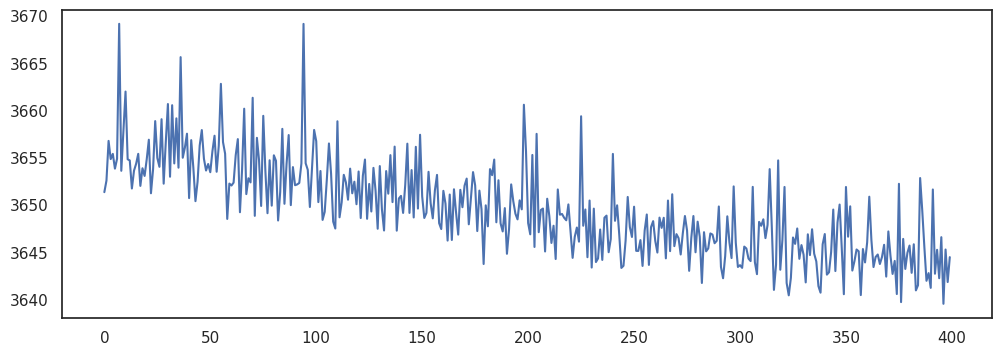

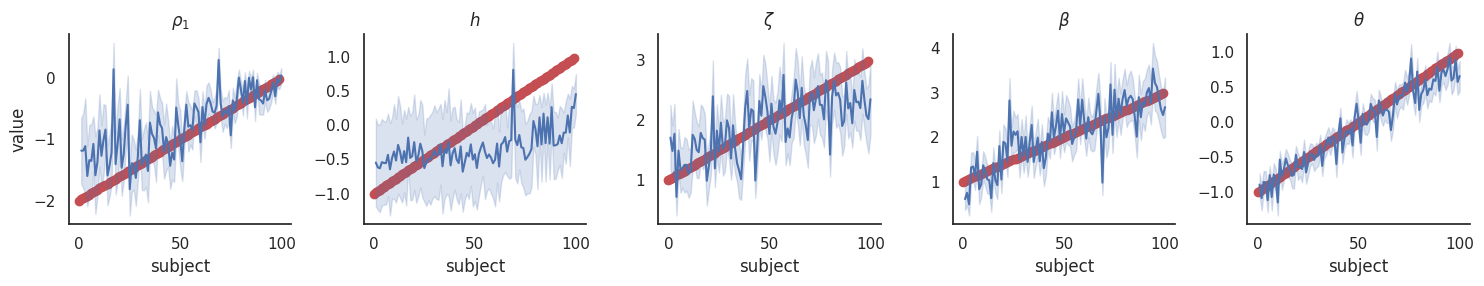

In [ ]:
plt.figure(figsize=(12, 4))
# plot convergence of stochasitc ELBO estimates (log-model evidence)
plt.plot(results["loss"][-400:])

g = sns.FacetGrid(trans_pars_sgf, col="parameter", height=3, sharey=False)
g = g.map(sns.lineplot, "subject", "value", errorbar="sd")

labels = [r"$\rho_1$", r"$h$", r"$\zeta$", r"$\beta$", r"$\theta$"]
for i in range(len(labels)):
    g.axes[0, i].plot(np.arange(2 * nsub), trans_pars3[:, i].numpy(), "ro", zorder=0)
    g.axes[0, i].set_title(labels[i])

Test model comparison

In [ ]:
for i in range(3):
    stimuli['pair_{}'.format(i)].update({'mask': torch.ones(1, 120, 100)})

rl_infer = [Horseshoe(rl_agent, stimuli['pair_0'], responses['pair_0']),
            Horseshoe(rl_agent, stimuli['pair_1'], responses['pair_1']),
            Horseshoe(rl_agent, stimuli['pair_2'], responses['pair_2'])]

evidences = torch.zeros(3, 3, 2 * nsub)
for i in range(3):
    rl_infer[i].infer_posterior(iter_steps=1000)
    evidences[0, i] = rl_infer[i].get_log_evidence_per_subject()
    
hgf_infer = [Horseshoe(hgf_agent, stimuli['pair_0'], responses['pair_0']),
             Horseshoe(hgf_agent, stimuli['pair_1'], responses['pair_1']),
             Horseshoe(hgf_agent, stimuli['pair_2'], responses['pair_2'])]

for i in range(3):
    hgf_infer[i].infer_posterior(iter_steps=1000)
    evidences[1, i] = hgf_infer[i].get_log_evidence_per_subject()
    
sgf_infer = [Horseshoe(sgf_agent, stimuli['pair_0'], responses['pair_0']),
             Horseshoe(sgf_agent, stimuli['pair_1'], responses['pair_1']),
             Horseshoe(sgf_agent, stimuli['pair_2'], responses['pair_2'])]

for i in range(3):
    sgf_infer[i].infer_posterior(iter_steps=1000)
    evidences[2, i] = sgf_infer[i].get_log_evidence_per_subject()

Mean ELBO 3705.91: 100%|█████████████████████| 1000/1000 [06:53<00:00,  2.42it/s]


In [ ]:
print((evidences[:, 0].argmax(dim=0) == 0).sum().float()/(2*nsub))
print((evidences[:, 1].argmax(dim=0) == 1).sum().float()/(2*nsub))
print((evidences[:, 2].argmax(dim=0) == 2).sum().float()/(2*nsub))
evidences.sum(-1)

tensor(0.6800)
tensor(0.3300)
tensor(0.4500)


tensor([[-4197.6558, -4809.9990, -3716.1531],
        [-4232.6968, -4810.6689, -3996.1685],
        [-4295.4995, -4861.0249, -3701.2620]])

The diagonal elements in the above matrix are not always the lowest values for the corresponding column, which shows that we cannot accuretly infer the correct model over population, and probably not per subject. More detailed analysis of the possible parameteric models is required.